In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.utils import resample

In [3]:
df_train = pd.read_csv(r"D:\Soteria_NLP\Raw_files\train.tsv", sep ='\t' )
df_test = pd.read_csv(r"D:\Soteria_NLP\Raw_files\test.tsv", sep= '\t')
df_dev = pd.read_csv(r"D:\Soteria_NLP\Raw_files\dev.tsv", sep = '\t')

print(df_train.head())
print(df_test.head())
print(df_dev.head())

           PID                                          Text_data     Label
0  train_pid_1  Waiting for my mind to have a breakdown once t...  moderate
1  train_pid_2  My new years resolution : I'm gonna get my ass...  moderate
2  train_pid_3  New year : Somone else Feeling like 2020 will ...  moderate
3  train_pid_4  My story I guess : Hi, Im from Germany and my ...  moderate
4  train_pid_5  Sat in the dark and cried myself going into th...  moderate
          Pid                                          text data Class labels
0  test_pid_1  Im scared : This is it. I lie to myself every ...     moderate
1  test_pid_2  New to this but just wanted to vent : I just f...     moderate
2  test_pid_3  I’m sad : It’s kinda always been an issue. I w...     moderate
3  test_pid_4  Lonely but not alone. : All of my immediately ...     moderate
4  test_pid_5  This year has been trash. : I dont know why I’...     moderate
         PID                                          Text data     Label
0 

In [4]:
print(df_train.info())
print(df_test.info())
print(df_dev.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8891 entries, 0 to 8890
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   PID        8891 non-null   object
 1   Text_data  8891 non-null   object
 2   Label      8891 non-null   object
dtypes: object(3)
memory usage: 208.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3245 entries, 0 to 3244
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Pid           3245 non-null   object
 1   text data     3245 non-null   object
 2   Class labels  3245 non-null   object
dtypes: object(3)
memory usage: 76.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4496 entries, 0 to 4495
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   PID        4496 non-null   object
 1   Text data  4496 non-null   object
 2   Label      4496 non-nul

In [5]:
print(df_train['Label'].value_counts())
print(df_test['Class labels'].value_counts())
print(df_dev['Label'].value_counts())

moderate          6004
not depression    1985
severe             902
Name: Label, dtype: int64
moderate          2169
not depression     848
severe             228
Name: Class labels, dtype: int64
moderate          2306
not depression    1830
severe             360
Name: Label, dtype: int64


In [6]:
df2_train = df_train.copy()

# EXP- 1

In [7]:
import re
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove all the special characters
    text = re.sub(r'\W', ' ', str(text))

    # Remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    

    # Substitute multiple spaces with single space
    text = re.sub(r'\s+|\d+', ' ', text, flags=re.I)

    # Convert to lowercase
    text = text.lower()

    # Lemmatization
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text if not word in stop_words]
    text = ' '.join(text)
    
    return text


df_train['Text_data'] = df_train['Text_data'].apply(preprocess_text)

In [8]:
X = df_train['Text_data']
y= df_train['Label']

In [9]:
y.value_counts()

moderate          6004
not depression    1985
severe             902
Name: Label, dtype: int64

In [10]:
# Splitting the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

In [11]:
y_train.value_counts()

moderate          4803
not depression    1588
severe             721
Name: Label, dtype: int64

In [12]:
import nltk
import random
from nltk.corpus import wordnet

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)
        
def synonym_replacement(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n: 
            break

    sentence = ' '.join(new_words)
    return sentence

def augment_text(df, class_name, augment_times=2):
    new_data = df.copy()
    for i in range(augment_times):
        for idx in df[df['Label'] == class_name].index:
            text = df.loc[idx, 'Text_data']
            words = text.split(' ')
            n = max(1, int(len(words)*0.1))
            new_text = synonym_replacement(words, n)
            new_row = {'Text_data': new_text, 'Label': class_name}
            new_data = new_data.append(new_row, ignore_index=True)
    return new_data

# Combine X_train and y_train into a DataFrame
df_train1 = pd.DataFrame({
    'Text_data': X_train,
    'Label': y_train
})

# Perform data augmentation
df_train_augmented = augment_text(df_train1, 'severe', 2)

C:\Users\navee\AppData\Local\Temp\ipykernel_8200\2230825781.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_data = new_data.append(new_row, ignore_index=True)
C:\Users\navee\AppData\Local\Temp\ipykernel_8200\2230825781.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_data = new_data.append(new_row, ignore_index=True)
C:\Users\navee\AppData\Local\Temp\ipykernel_8200\2230825781.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_data = new_data.append(new_row, ignore_index=True)
C:\Users\navee\AppData\Local\Temp\ipykernel_8200\2230825781.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_data = new_data.append(

In [13]:
df_train_augmented['Label'].value_counts()

moderate          4803
severe            2163
not depression    1588
Name: Label, dtype: int64

In [14]:
# Separate the classes
not_depressed = df_train_augmented[df_train_augmented['Label'] == 'not depression']
moderate = df_train_augmented[df_train_augmented['Label'] == 'moderate']
severe = df_train_augmented[df_train_augmented['Label'] == 'severe']

# Undersampling the 'moderate' class
moderate_downsampled = resample(moderate, replace=False, n_samples=len(severe), random_state=42)

# Resampling 'not depression' class to match the number of 'severe' instances
not_depressed_upsampled = resample(not_depressed, replace=True, n_samples=len(severe), random_state=42)

# Combine upsampled 'not depression' with other classes
balanced = pd.concat([not_depressed_upsampled, moderate_downsampled, severe])

# Shuffle the DataFrame rows 
balanced = balanced.sample(frac=1, random_state=42)




In [15]:
balanced['Label'].value_counts()

moderate          2163
severe            2163
not depression    2163
Name: Label, dtype: int64

In [16]:
X_train_aug = df_train['Text_data']
y_train_aug= df_train['Label']

In [17]:
# Label encoding
le = LabelEncoder()
y_train_aug = le.fit_transform(y_train_aug)
y_val = le.transform(y_val)

In [18]:
# Retrieve original labels
original_labels = le.classes_

# Print the mapping between encoded values and original labels
for encoded_value, original_label in enumerate(original_labels):
    print(f"Encoded value {encoded_value} corresponds to label '{original_label}'")

Encoded value 0 corresponds to label 'moderate'
Encoded value 1 corresponds to label 'not depression'
Encoded value 2 corresponds to label 'severe'


In [19]:
# Converting the labels back to categorical
y_train_aug = to_categorical(y_train_aug)
y_val = to_categorical(y_val)

In [20]:
y_train_aug[0:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [21]:
X_train_aug.head()

0    waiting mind breakdown new year feeling anymor...
1    new year resolution gonna get as therapist off...
2    new year somone else feeling like last year ea...
3    story guess hi im germany english mostly self ...
4            sat dark cried going new year great start
Name: Text_data, dtype: object

In [22]:
sequence_lengths = [len(seq.split()) for seq in X_train_aug]

average_length = np.mean(sequence_lengths)
median_length = np.median(sequence_lengths)

print("Average Length: ", average_length)
print("Median Length: ", median_length)


Average Length:  65.0291305814869
Median Length:  38.0


In [23]:
max_length = np.percentile(sequence_lengths, 90)
print("Max Length: ", max_length)


Max Length:  150.0


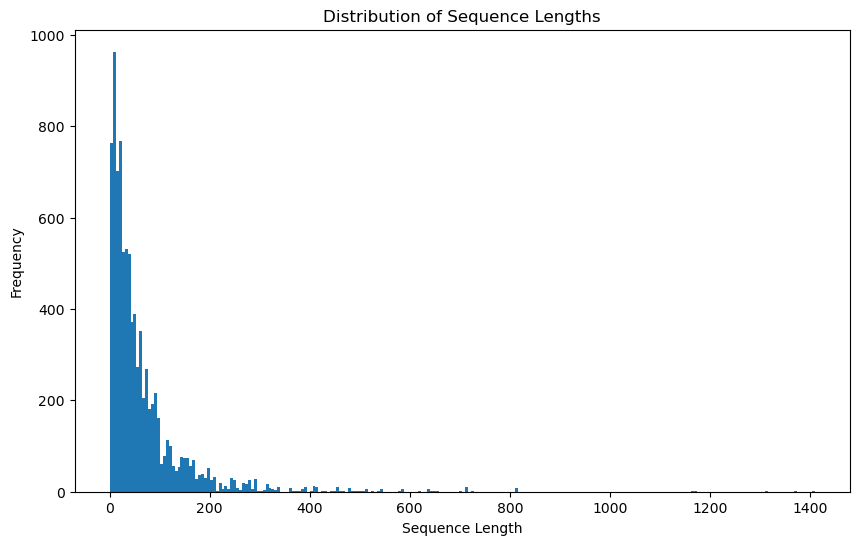

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins='auto')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()


In [25]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Define maximum number of words to consider as features
max_features = 1000
# Define maximum length of a sequence
max_length = 200

# Prepare the tokenizer
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train_aug)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_aug)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad the sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length)


# RNN

In [26]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

# Define maximum number of words to consider as features
max_features = 10000  # updated as per your new choice
# Define maximum length of a sequence
max_length = 150  # updated based on your sequence length analysis

# Prepare the tokenizer
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train_aug)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_aug)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad the sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length)

from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(3, activation='softmax'))  # Assuming you have 3 classes

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)


history = model.fit(X_train_pad, y_train_aug, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val_pad, y_val),
                     callbacks=[early_stopping])


Epoch 1/50
278/278 [==============================] - 8s 25ms/step - loss: 0.6021 - acc: 0.7680 - val_loss: 0.3260 - val_acc: 0.8909
Epoch 2/50
278/278 [==============================] - 7s 24ms/step - loss: 0.2737 - acc: 0.8960 - val_loss: 0.1679 - val_acc: 0.9455
Epoch 3/50
278/278 [==============================] - 7s 24ms/step - loss: 0.1530 - acc: 0.9469 - val_loss: 0.0924 - val_acc: 0.9758
Epoch 4/50
278/278 [==============================] - 7s 24ms/step - loss: 0.0872 - acc: 0.9746 - val_loss: 0.0575 - val_acc: 0.9865
Epoch 5/50
278/278 [==============================] - 7s 24ms/step - loss: 0.0588 - acc: 0.9834 - val_loss: 0.0375 - val_acc: 0.9927
Epoch 6/50
278/278 [==============================] - 7s 25ms/step - loss: 0.0458 - acc: 0.9890 - val_loss: 0.0298 - val_acc: 0.9938
Epoch 7/50
278/278 [==============================] - 7s 25ms/step - loss: 0.0344 - acc: 0.9926 - val_loss: 0.0243 - val_acc: 0.9944
Epoch 8/50
278/278 [==============================] - 7s 24ms/step - 

In [27]:
# Predict the probabilities
y_val_probs = model.predict(X_val_pad)

# Define your thresholds here
thresholds = [0.5, 0.25, 0.5]

# Create an array to store your predictions
predictions = np.zeros_like(y_val_probs)

# Apply the thresholds to assign class labels
for i in range(y_val_probs.shape[1]):
    predictions[:, i] = (y_val_probs[:, i] > thresholds[i]).astype(int)

# Now each row in 'predictions' holds the predicted labels for each class


56/56 [==============================] - 1s 6ms/step


In [28]:
from sklearn.metrics import accuracy_score

# Get the true labels
y_val_true = np.argmax(y_val, axis=-1) 

 
# Get the predicted labels
y_val_pred = np.argmax(predictions, axis=-1)  

# Calculate the accuracy
accuracy = accuracy_score(y_val_true, y_val_pred)

print("Validation accuracy with custom thresholds: ", accuracy)


Validation accuracy with custom thresholds:  0.9921304103428893


# Evaluating test data and dev data

In [29]:
df_test.head()

,Pid,text data,Class labels
0,test_pid_1,Im scared : This is it. I lie to myself every ...,moderate
1,test_pid_2,New to this but just wanted to vent : I just f...,moderate
2,test_pid_3,I’m sad : It’s kinda always been an issue. I w...,moderate
3,test_pid_4,Lonely but not alone. : All of my immediately ...,moderate
4,test_pid_5,This year has been trash. : I dont know why I’...,moderate


In [30]:
df_test['text data'] = df_test['text data'].apply(preprocess_text)


In [31]:
X_test = df_test['text data']
y_test = df_test['Class labels']

In [32]:
y_test = le.transform(y_test)
y_test = to_categorical(y_test)

In [33]:
y_test[0:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [34]:
# Convert texts to sequences
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

# Predict the probabilities
y_test_probs = model.predict(X_test_pad)

# Apply the thresholds to assign class labels
predictions = np.zeros_like(y_test_probs)
for i in range(y_test_probs.shape[1]):
    predictions[:, i] = (y_test_probs[:, i] > thresholds[i]).astype(int)

# Get the true labels
y_test_true = np.argmax(y_test, axis=-1)

# Get the predicted labels
y_test_pred = np.argmax(predictions, axis=-1)

# Calculate the accuracy
accuracy = accuracy_score(y_test_true, y_test_pred)

print("Test accuracy with custom thresholds: ", accuracy)


102/102 [==============================] - 1s 6ms/step
Test accuracy with custom thresholds:  0.4613251155624037


# dev data

In [35]:
df_dev.head()

,PID,Text data,Label
0,dev_pid_1,"I enjoyed today, and I still am! Tomorrows dep...",moderate
1,dev_pid_2,I sorta tried to kill myself : I had a total b...,moderate
2,dev_pid_3,Best suicide method? : I like it quick and eas...,moderate
3,dev_pid_4,a story : I remember the time I'd get on my 3D...,moderate
4,dev_pid_5,The world only cares about beautiful people : ...,moderate


In [36]:
df_dev.columns

Index(['PID', 'Text data', 'Label'], dtype='object')

In [37]:
df_dev['Text data'] = df_dev['Text data'].apply(preprocess_text)
X_dev = df_dev['Text data']
y_dev = df_dev['Label']

y_dev = le.transform(y_dev)
y_dev = to_categorical(y_dev)


# Convert texts to sequences
X_dev_seq = tokenizer.texts_to_sequences(X_dev)

# Pad the sequences
X_dev_pad = pad_sequences(X_dev_seq, maxlen=max_length)

# Predict the probabilities
y_dev_probs = model.predict(X_dev_pad)

# Apply the thresholds to assign class labels
predictions_dev = np.zeros_like(y_dev_probs)
for i in range(y_dev_probs.shape[1]):
    predictions_dev[:, i] = (y_dev_probs[:, i] > thresholds[i]).astype(int)

# Get the true labels
y_dev_true = np.argmax(y_dev, axis=-1)

# Get the predicted labels
y_dev_pred = np.argmax(predictions_dev, axis=-1)

# Calculate the accuracy
accuracy_dev = accuracy_score(y_dev_true, y_dev_pred)

print("Development set accuracy with custom thresholds: ", accuracy_dev)


141/141 [==============================] - 1s 6ms/step
Development set accuracy with custom thresholds:  0.4472864768683274


In [38]:
df_dev.head()

,PID,Text data,Label
0,dev_pid_1,enjoyed today still tomorrow depression wait t...,moderate
1,dev_pid_2,sorta tried kill total breakdown fucking car p...,moderate
2,dev_pid_3,best suicide method like quick easy deformity ...,moderate
3,dev_pid_4,story remember time get d play nintendogs gran...,moderate
4,dev_pid_5,world care beautiful people born ugly always u...,moderate


# LSTM

In [39]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Build the model
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))  # Use LSTM instead of SimpleRNN
model.add(Dense(3, activation='softmax'))  # Assuming you have 3 classes

# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(X_train_pad, y_train_aug, 
                    epochs=25, 
                    batch_size=32, 
                    validation_data=(X_val_pad, y_val),
                    callbacks=[early_stopping])

# Predict the probabilities
y_val_probs = model.predict(X_val_pad)

# Define your thresholds here
thresholds = [0.5, 0.25, 0.5]

# Create an array to store your predictions
predictions = np.zeros_like(y_val_probs)

# Apply the thresholds to assign class labels
for i in range(y_val_probs.shape[1]):
    predictions[:, i] = (y_val_probs[:, i] > thresholds[i]).astype(int)

# Get the true labels
y_val_true = np.argmax(y_val, axis=-1) 

# Get the predicted labels
y_val_pred = np.argmax(predictions, axis=-1)  

# Calculate the accuracy
accuracy = accuracy_score(y_val_true, y_val_pred)

print("Validation accuracy with custom thresholds: ", accuracy)


Epoch 1/25
278/278 [==============================] - 14s 44ms/step - loss: 0.7322 - acc: 0.7124 - val_loss: 0.5492 - val_acc: 0.7943
Epoch 2/25
278/278 [==============================] - 12s 44ms/step - loss: 0.4413 - acc: 0.8403 - val_loss: 0.3303 - val_acc: 0.8848
Epoch 3/25
278/278 [==============================] - 12s 42ms/step - loss: 0.3022 - acc: 0.8923 - val_loss: 0.2554 - val_acc: 0.9179
Epoch 4/25
278/278 [==============================] - 12s 42ms/step - loss: 0.2416 - acc: 0.9158 - val_loss: 0.2269 - val_acc: 0.9252
Epoch 5/25
278/278 [==============================] - 11s 41ms/step - loss: 0.2003 - acc: 0.9316 - val_loss: 0.1693 - val_acc: 0.9399
Epoch 6/25
278/278 [==============================] - 12s 43ms/step - loss: 0.1763 - acc: 0.9387 - val_loss: 0.1463 - val_acc: 0.9483
Epoch 7/25
278/278 [==============================] - 12s 44ms/step - loss: 0.1530 - acc: 0.9464 - val_loss: 0.1332 - val_acc: 0.9545
Epoch 8/25
278/278 [==============================] - 12s 42ms

In [40]:
from sklearn.metrics import classification_report

# Calculate the classification report
report = classification_report(y_val_true, y_val_pred, target_names=original_labels)

print(report)


                precision    recall  f1-score   support

      moderate       0.99      1.00      0.99      1201
not depression       0.97      0.98      0.97       397
        severe       1.00      0.92      0.96       181

      accuracy                           0.99      1779
     macro avg       0.99      0.96      0.97      1779
  weighted avg       0.99      0.99      0.99      1779



In [41]:
# Now, let's evaluate on test data
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)
y_test_pred_probs = model.predict(X_test_pad)

# Get the predicted labels
y_test_pred = np.argmax(y_test_pred_probs, axis=-1)

# Calculate the accuracy
accuracy = accuracy_score(y_test_true, y_test_pred)
print("Test accuracy without custom thresholds: ", accuracy)

102/102 [==============================] - 1s 13ms/step
Test accuracy without custom thresholds:  0.5513097072419106


In [42]:
# Apply the thresholds to assign class labels
predictions = np.zeros_like(y_test_pred_probs)
for i in range(y_test_pred_probs.shape[1]):
    predictions[:, i] = (y_test_pred_probs[:, i] > thresholds[i]).astype(int)

# Get the true labels
y_test_true = np.argmax(y_test, axis=-1)

# Get the predicted labels
y_test_pred = np.argmax(predictions, axis=-1)

# Calculate the accuracy
accuracy = accuracy_score(y_test_true, y_test_pred)
print("Test accuracy with custom thresholds: ", accuracy)


Test accuracy with custom thresholds:  0.5522342064714946


In [52]:
df_test = df_test.assign(predicted_classes = y_test_pred)


In [53]:
df_test.head()

,Pid,text data,Class labels,predicted_classes,predicted_scores
0,test_pid_1,im scared lie every day say ill make think mig...,moderate,0,0.994132
1,test_pid_2,new wanted vent finally realized kind bad ment...,moderate,0,0.998149
2,test_pid_3,sad kinda always issue say bad peer definitely...,moderate,1,0.999889
3,test_pid_4,lonely alone immediately family member dead da...,moderate,0,0.840529
4,test_pid_5,year trash dont know posting even know talking...,moderate,0,0.951837


In [56]:
def calculate_raw_scores(y_probs, y_pred):
    raw_scores = []
    for prob, pred in zip(y_probs, y_pred):
        if pred == 0:  # Scores from 0.25 to 0.5
            raw_score = prob[0] * 0.25 + 0.25
        elif pred == 1:  # Scores from 0 to 0.25
            raw_score = prob[1] * 0.25
        else:  # pred == 2, scores from 0.5 to 1
            raw_score = prob[2] * 0.5 + 0.5
        raw_scores.append(raw_score)
    return np.array(raw_scores)

raw_scores = calculate_raw_scores(y_test_pred_probs, y_test_pred)

# Add to the dataframe
df_test['predicted_raw_scores'] = raw_scores


In [59]:
df_test.head()

,Pid,text data,Class labels,predicted_classes,predicted_raw_scores
0,test_pid_1,im scared lie every day say ill make think mig...,moderate,0,0.498533
1,test_pid_2,new wanted vent finally realized kind bad ment...,moderate,0,0.499537
2,test_pid_3,sad kinda always issue say bad peer definitely...,moderate,1,0.249972
3,test_pid_4,lonely alone immediately family member dead da...,moderate,0,0.460132
4,test_pid_5,year trash dont know posting even know talking...,moderate,0,0.487959


In [58]:
df_test.drop(columns='predicted_scores', axis=1, inplace=True)

In [60]:
df_test.to_csv('provisional_results.csv', index=False)

In Experiment 1, the task of text classification was undertaken with an imbalanced multi-class dataset using Recurrent Neural Networks (RNNs) and Long Short-Term Memory networks (LSTMs). The process encompassed essential steps of text preprocessing and data augmentation, addressing the challenge of class imbalance. This led to a high model performance on the training and validation sets, with an accuracy of around 99%.

However, the performance significantly dropped on the test and dev sets to about 45%, indicating a potential issue with overfitting or model complexity. These insights hint at potential areas for improvement and refinement in the methodology.

Moving forward, it's important to delve deeper into text preprocessing techniques and examine other imbalance handling methods. Utilizing pre-trained models for richer, contextual representations and testing different model architectures may also be beneficial. Additionally, advanced techniques like attention mechanisms or capsule networks and hyperparameter optimization should also be considered to improve model performance. Thus, while the initial experiment offered valuable insights into text classification challenges, there are various avenues open for enhancement and optimization.